In [2]:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing  

import math              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cmath 
from sympy import symbols, I, exp, diff, lambdify
from scipy.optimize import minimize

# Computing the Intensity Profile of a Yagi Uda Antenna

In [3]:
"All lengths given in units of the wavelength lambda"
l_1 =  [0.5, 0.48, 0.46, 0.46, 0.46, 0.46] #antenna lengths. 
l_2 =[0.003, 0.003, 0.003, 0.003, 0.003, 0.003] #antenna radii
l_3 = [(0,0), (0.125,0), (0.25,0), (0.375, 0), (0.5, 0),(0.625,0)] #antenna position

V = [0, 1, 0, 0, 0,0] #voltage in each antenna

def G_new(p, q, k, z, z_1, L_1, L_2, L_3):
   
    """

    Parameters
    ----------
    p, q: antenna indexes
    k : wavenumber
    z : 
    z_1 : z'
    L_1, L_2, L_3: list of antennas characteristic (ordered in the same order as the antennas in the linear array)
    Returns so called impedance kernel=Green function, used to compute the impedance coefficients
    -------
    """

    #print(L_2)
    if p == q:
        d = L_2[p]
    else:
        d = math.sqrt((L_3[p][0] - L_3[q][0])**2+ (L_3[p][1] - L_3[q][1])**2)
    #print(d)
    R = math.sqrt((z - z_1)**2 + d**2)
    if R < 1e-6:  # threshold for small distances
        return 0 
    #print(R)
    return (cmath.exp(-k * R*1j))/R


def Z_new(p, q, k=1):
    """
    Compute the coefficient of entry (p, q) of the impedance matrix (after integration by part). 
    In fact, no need to put k as argument.
    Note: The same formula can be retrieved with the near-field expression
    p, q: index of coeff Zpq in the impedance matrix

    """
    global l_1, l_2, l_3
    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l_1]
    L_2 = [l*wavelength for l in l_2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l_3]
    h_p = L_1[p]/2
    h_q = L_1[q]/2
    if p == q:
        N = 500 
    else:
        N = 300
    Z = 0
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    
    for n in range(-N//2, N//2+1):
        z_1 = (n*2*h_q)/N
        dz_1 = 2*h_q/N
        g1 = G_new(p, q, k, h_p, z_1, L_1, L_2, L_3)
        g2 = G_new(p, q, k, -h_p, z_1, L_1, L_2, L_3)
        g3 = G_new(p, q, k, 0, z_1, L_1, L_2, L_3)
        sinq = math.sin(k*(h_q- abs(z_1)))
        Z += sinq*(g1+g2-2*np.cos(k*h_p)*g3)*dz_1
    Z = Z*(complex(0, eta/(4*math.pi)))*1/(np.sin(k*h_p)*np.sin(k*h_q))          
    return Z   

In [4]:
def matrixZ_new(k):
    """
    Compute the impedance matrix Z for antenna arrays
    
    """
    n = len(l_1) #nb of antennas
    #matZ = np.matrix([[Z(p,q,k) for q in range(0,n)] for p in range(0,n)])
    matZ= np.zeros((n, n), dtype=complex)
    for p in range(0, n):
        for q in range(0, p+1):
            Z_pq =  Z_new(p,q,k)
            if p == q:
                matZ[p][q] = Z_pq
            else:
                matZ[p][q] = Z_pq
                matZ[q][p] = Z_pq
    return matZ

In [5]:
def input_current(V,Z):
    I = np.linalg.solve(Z, V)
    return I  

In [6]:
V = [0, 1]+[0]*(len(l_1)-2) #=[0, 1, 0, 0, 0] for 5 elements

In [51]:
def radiation_intensity(k, theta, phi, l1,l2,l3):
    """
    Radiation intensity for the SPECIFIC case of antenna arrays along x-axis, which needs to be refined for other types.
    k: wavenumber of the emitted wave
    theta, phi: spherical coordinates
    Issue solved at theta = 0, theta = pi
    """
    def identify_vector_arg(theta, phi):
        if np.ndim(theta) > 0:
            vector_arg = theta
        else:
            vector_arg = phi
        return vector_arg

    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l1]
    L_2 = [l*wavelength for l in l2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l3]
    
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    I = input_current(V,matrixZ_new(k))
    
    M = identify_vector_arg(theta, phi)
    U = np.zeros_like(M, dtype=complex)  # to accumulate field
    for p in range(0, len(L_1)):
        h_p = L_1[p]/2
        term1 = np.exp(1j*k*np.sin(theta)*L_3[p][0]*np.cos(phi))
        if M is theta:
            mask = (theta != 0) & (theta != np.pi) #to deal with division by 0 at theta = 0 and theta = pi
            term2 = np.zeros_like(theta)
            term2[mask] = (np.cos(k*h_p*np.cos(theta[mask]))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta[mask]))
        elif theta == 0 or theta == np.pi:
            term2 = np.zeros_like(theta)
        else:
            term2 =  (np.cos(k*h_p*np.cos(theta))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta))
        U += I[p]*term1*term2
    return (eta/(8*np.pi**2))*abs(U)**2

def decibels_radiation(k, theta, phi, l1,l2,l3):
    
    return 10*np.log10(radiation_intensity(k, theta, phi, l1,l2,l3))

def radiation_theta(k, phi, l1, l2, l3):
    theta = np.linspace(-np.pi, np.pi, 500)  # θ from 0 to π (forward and backward hemisphere)
    U = decibels_radiation(k, theta, phi, l1, l2, l3)


    # Plot in polar coordinates
    #fig = plt.figure(figsize=(6, 6))
    #ax = plt.subplot(111, projection='polar')
    #ax.plot(theta, U)
    #ax.set_title(f"Radiation Pattern at φ = {phi} (polar)", va='bottom')
    #ax.grid(True)
    #ax.set_rlim(-50, 0)

    #plt.show()

    return U, theta


def radiation_phi(k, theta, l1, l2, l3):
    phi = np.linspace(-np.pi, np.pi, 500)  # azimuthal angle range
    U = decibals_radiation(k, theta, phi, l1, l2, l3)

    # Plot in polar coordinates
    #fig = plt.figure(figsize=(6, 6))
    #ax = plt.subplot(111, projection='polar')
    #ax.plot(phi, U)
    #ax.set_title(f"Radiation Pattern at θ = {theta} (polar)", va='bottom')
    #ax.grid(True)
    #ax.set_rlim(-50, 0)

    #plt.show()

    return U, phi
    

# Investigating the Beam Width of a Yagi Uda Configuration

In [52]:
def beam_width_theta(k, phi, l1, l2, l3):
    # Compute radiation intensity and theta values once
    U =  radiation_theta(k,phi,l1,l2,l3)[0]
    theta = radiation_theta(k,phi,l1,l2,l3)[1]

    # Half-power threshold
    U_half = np.max(U) / 2
    deltaU = U - U_half

    indices = []
    i = 0
    while i < len(deltaU) - 1:
        # Falling edge: U > U_half to U < U_half
        while i < len(deltaU) - 1 and deltaU[i] > 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

        # Rising edge: U < U_half to U > U_half
        while i < len(deltaU) - 1 and deltaU[i] < 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

    # Final filter: remove any crossings where theta ≈ π (e.g. > π - 0.01)
    indices = [idx for idx in indices if theta[idx] < np.pi - 1e-2]


    if len(indices) < 2:
        print("Could not find enough valid half-power points.")
        return None
    


    # Beamwidth across all valid lobes
    return abs(theta[indices[-1]] - theta[indices[0]])

In [53]:
beam_width_theta(2*np.pi,0,l_1,l_2,l_3)

Could not find enough valid half-power points.


C:\Users\mattc\AppData\Local\Temp\ipykernel_30132\4183326593.py:41: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(radiation_intensity(k, theta, phi, l1,l2,l3))


In [54]:
def seperation_beamwidth_relation(k, l1, l2):
    # Generate separations from 0.1 to 1.0
    sep = np.linspace(0.1, 5.0, 500)

    # Create array of element positions for each separation
    configs = [[(i * dist, 0) for i in range(5)] for dist in sep]

    # Calculate beamwidths
    beam_widths = np.array([
        beam_width_theta(k,0, l1, l2, config) for config in configs
    ])

    # Find the separation that gives the minimum beamwidth
    min_index = np.nanargmin(beam_widths)
    min_sep = sep[min_index]
    min_beamwidth = beam_widths[min_index]

    # Plot
    plt.plot(sep, beam_widths, label='Beamwidth vs Separation')
    plt.axvline(x=min_sep, color='r', linestyle='--', label=f'Min @ {min_sep:.3f}')
    plt.scatter([min_sep], [min_beamwidth], color='red')  # highlight min point
    plt.xlabel("Separation (λ)")
    plt.ylabel("Beamwidth (radians)")
    plt.title("Relation Between Element Separation and Beamwidth")
    plt.grid(True)
    plt.legend()
    plt.show()

    return min_sep

## Computation of the Directivity by Yagi

In [55]:
def directivity(k, theta, phi, l1, l2, l3):
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')  # shape (len(theta), len(phi))

    # Compute radiation intensity U(θ, φ)
    U = radiation_intensity(k, THETA, PHI, l1, l2, l3)  # shape (len(theta), len(phi))

    # Integrate total radiated power
    integrand = U * np.sin(THETA)

    P_rad = np.trapz(np.trapz(integrand, axis=1), axis=0)

    if np.isclose(P_rad, 0):
        raise ValueError("P_rad evaluated to 0. Check radiation_intensity and inputs.")
    
    
    # Directivity
    D = 4 * np.pi * U / P_rad
    if np.any(D < 0):
        raise ValueError("Directivity contains negative values. Check radiation intensity calculation.")
    #A negative dB simply means the directivity is less than 1 
    #(i.e., it's radiating less intensely in the peak direction than an isotropic radiator would).
    #In the case of Yagi, it should not happen along positive x.
    return f'The directivity is {D}, or {10*np.log10(D)} dB'

In [56]:
def directivity_plot_2D_azimuthal(k, l1, l2, l3, phi):
    """
    Plots the 2D directivity pattern (in dB) vs theta (standard Cartesian plot).
    
    Parameters:
        k   : wave number (2π / wavelength)
        l1, l2, l3 : geometric antenna parameters
        phi : azimuth angle in radians (constant during θ sweep)
    """
    # Theta sweep
    theta = np.linspace(0, 2*np.pi, 500)
    phi_array = np.full_like(theta, phi)

    # Compute directivity
    D = directivity(k, theta, phi_array, l1, l2, l3)

    # Normalize and convert to dB
    D_norm = D
    D_db = 10 * np.log10(D_norm + 1e-12)
    D_db = np.clip(D_db, -50, 0)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(theta * 180 / np.pi, D_db)  # Convert θ to degrees
    plt.xlabel("Theta (degrees)")
    plt.ylabel("Directivity (dB)")
    plt.title(f"Directivity vs Theta at φ = {phi:.2f} rad")
    plt.ylim(-50, 0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [57]:
directivity_plot_2D_azimuthal(1.047,l_1,l_2,l_3, 0)

C:\Users\mattc\AppData\Local\Temp\ipykernel_30132\1364454486.py:23: RuntimeWarning: divide by zero encountered in log10
  return f'The directivity is {D}, or {10*np.log10(D)} dB'


TypeError: can only concatenate str (not "float") to str

In [58]:
def directivity_vs_phi(k, l1, l2, l3, theta):
    """
    Plots directivity (in dB) vs phi at fixed theta (Cartesian plot).

    Parameters:
        k     : wave number (2π / wavelength)
        l1, l2, l3 : antenna geometry parameters
        theta : fixed elevation angle (radians)
    """
    # Sweep phi from 0 to 2π
    phi = np.linspace(0, 2 * np.pi, 500)
    theta_array = np.full_like(phi, theta)  # Fixed theta for all phi


    # Compute directivity
    D = directivity(k, phi, theta_array, l1, l2, l3)

    # Normalize and convert to dB
    D_norm = D 
    D_db = 10 * np.log10(D_norm + 1e-12)
    D_db = np.clip(D_db, -50, 0)

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(np.degrees(phi), D_db)
    plt.xlabel("Phi (degrees)")
    plt.ylabel("Directivity (dB)")
    plt.title(f"Directivity vs Phi at θ = {np.degrees(theta):.1f}°")
    plt.ylim(-50, 0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [59]:
directivity_vs_phi(1.047,l_1,l_2,l_3, np.pi/2)

ValueError: P_rad evaluated to 0. Check radiation_intensity and inputs.

In [17]:
def max_directivity_db(k, l1, l2, l3):
    """
    Computes the maximum directivity (in dB) over the full sphere.

    Parameters:
        k     : wave number (2π / wavelength)
        l1, l2, l3 : antenna geometry parameters

    Returns:
        max_D_dB : Maximum directivity in decibels
    """
    # Define angular grid
    theta = np.linspace(0, np.pi, 200)
    phi = np.linspace(0, 2 * np.pi, 200)
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')

    # Compute radiation intensity over the sphere
    U = radiation_intensity(k, THETA, PHI, l1, l2, l3)

    # Total radiated power
    integrand = U * np.sin(THETA)
    P_rad = np.trapz(np.trapz(integrand, axis=1), axis=0)

    if np.isclose(P_rad, 0):
        raise ValueError("Total radiated power is zero — check configuration.")

    # Directivity D(θ, φ) = 4π * U(θ, φ) / P_rad
    D = 4 * np.pi * U / P_rad
    D_max = np.max(D)

    # Convert to dB
    D_max_dB = 10 * np.log10(D_max + 1e-12)
    return D_max_dB

In [18]:
max_directivity_db(5,l_1,l_2,l_3)

-23.443903375464636

In [33]:
def plot_directivity_vs_spacing(k, l1, l2, spacing_range):
    """
    Plots maximum directivity (in dB) vs element spacing for a 5-element linear array.

    Parameters:
        k             : wave number (2π / wavelength)
        l1, l2        : geometric parameters (e.g., current tapering, etc.)
        spacing_range : 1D array of separations (in units of wavelength)
    """
    max_directivities = []

    for d in spacing_range:
        # Define positions along x-axis
        l3 = [(n * d, 0) for n in range(len(l1))]  # 5 elements
        D_max_dB = max_directivity_db(k, l1, l2, l3)
        max_directivities.append(D_max_dB)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(spacing_range, max_directivities, marker='o')
    plt.xlabel("Element Spacing (λ)")
    plt.ylabel("Max Directivity (dB)")
    plt.title("Maximum Directivity vs Element Spacing ("+str(len(l1))+"-element linear array)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

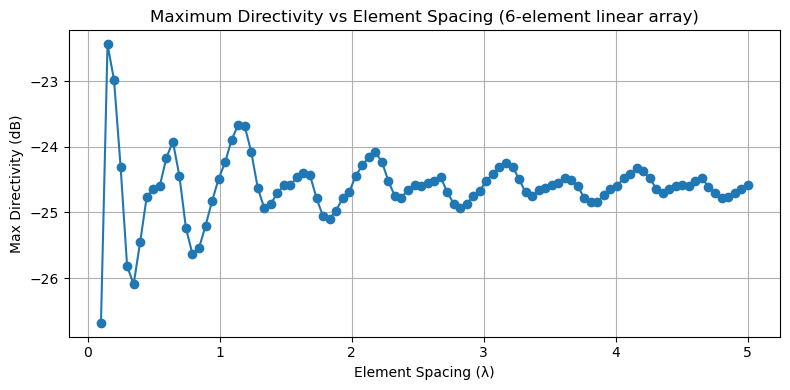

In [34]:
plot_directivity_vs_spacing(1,l_1,l_2,np.linspace(0.1,5,100))

In [45]:
k = 2 * np.pi  # wave number (assuming λ = 1)
l1 = [0.5] * 6
l2 = []

# Convert spacing vector to antenna element positions
def compute_positions(spacings):
    positions = [0]
    for s in spacings:
        positions.append(positions[-1] + s)
    return [(x, 0) for x in positions]  # linear Yagi array along x-axis

# Objective function to minimize (negated gain)
def objective(spacings):
    try:
        l3 = compute_positions(spacings)
        return -max_directivity_db(k, l1, l2, l3)
    except Exception as e:
        print("Error:", e)
        return 1e6  # penalize failures

# Initial guess and spacing bounds
initial_guess = [0.31] * 5
bounds = [(0.1, 0.6)] * 5  # spacing bounds in wavelengths

# Run optimization
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

# Extract results
opt_spacings = result.x
opt_l3 = compute_positions(opt_spacings)
opt_gain_db = -result.fun

# Report
print("✅ Optimization Complete")
print("Optimal Spacings (λ):", np.round(opt_spacings, 4))
print("Maximum Directivity (dB):", round(opt_gain_db, 2))


✅ Optimization Complete
Optimal Spacings (λ): [0.225  0.201  0.1    0.1794 0.1   ]
Maximum Directivity (dB): -21.66
